# Regrid between rectilinear grids


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe

In [5]:
! pip install pooch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.5 MB/s eta 0:00:00


## Prepare data


### Input data


We regrid xarray's built-in demo data. This data is also used by
[xarray plotting tutorial](http://xarray.pydata.org/en/stable/plotting.html).


In [6]:
ds = xr.tutorial.load_dataset("air_temperature") 

In [3]:
ds = xr.tutorial.open_dataset(
    "air_temperature"
)  # use xr.tutorial.load_dataset() for xarray<v0.11.0
ds

ImportError: tutorial.open_dataset depends on pooch to download and manage datasets. To proceed please install pooch.

It is the air temperature data over US with 2920 time frames. Let's plot the
first frame:


In [7]:
dr = ds["air"]  # get a DataArray

/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


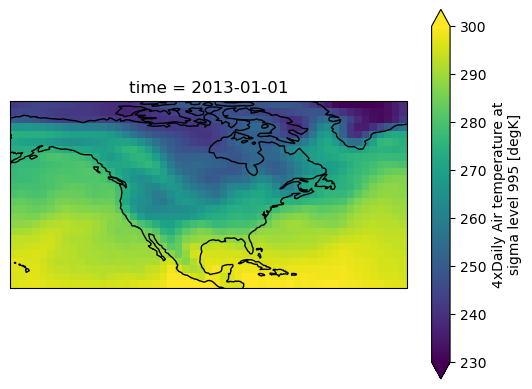

In [8]:
ax = plt.axes(projection=ccrs.PlateCarree())
dr.isel(time=0).plot.pcolormesh(ax=ax, vmin=230, vmax=300)
ax.coastlines()

### Input grid


Its grid resolution is $2.5^\circ \times 2.5^\circ$:


In [9]:
ds["lat"].values, ds["lon"].values

(array([75. , 72.5, 70. , 67.5, 65. , 62.5, 60. , 57.5, 55. , 52.5, 50. ,
        47.5, 45. , 42.5, 40. , 37.5, 35. , 32.5, 30. , 27.5, 25. , 22.5,
        20. , 17.5, 15. ], dtype=float32),
 array([200. , 202.5, 205. , 207.5, 210. , 212.5, 215. , 217.5, 220. ,
        222.5, 225. , 227.5, 230. , 232.5, 235. , 237.5, 240. , 242.5,
        245. , 247.5, 250. , 252.5, 255. , 257.5, 260. , 262.5, 265. ,
        267.5, 270. , 272.5, 275. , 277.5, 280. , 282.5, 285. , 287.5,
        290. , 292.5, 295. , 297.5, 300. , 302.5, 305. , 307.5, 310. ,
        312.5, 315. , 317.5, 320. , 322.5, 325. , 327.5, 330. ],
       dtype=float32))

### Output grid


Say we want to downsample it to $1.0^\circ \times 1.5^\circ$. Just define the
output grid as an xarray `Dataset`. Notice here that we take care of passing
some attributes to the coordinate variables. This ensures xESMF and it's
underlying helper, cf-xarray, understand which is which.


In [10]:
ds_out = xr.Dataset(
    {
        "lat": (["lat"], np.arange(16, 75, 1.0), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(200, 330, 1.5), {"units": "degrees_east"}),
    }
)
ds_out

<xarray.Dataset>
Dimensions:  (lat: 59, lon: 87)
Coordinates:
  * lat      (lat) float64 16.0 17.0 18.0 19.0 20.0 ... 70.0 71.0 72.0 73.0 74.0
  * lon      (lon) float64 200.0 201.5 203.0 204.5 ... 324.5 326.0 327.5 329.0
Data variables:
    *empty*

## Perform regridding


Make a regridder by `xe.Regridder(grid_in, grid_out, method)`. `grid` is just an
xarray `Dataset` containing `lat` and `lon` values. In most cases, `'bilinear'`
should be good enough. For other methods see
[Comparison of 5 regridding algorithms](./Compare_algorithms.ipynb).


In [13]:
regridder = xe.Regridder(ds, ds_out, 'bilinear')
regridder  # print basic regridder information.

Create weight file: bilinear_25x53_59x87.nc


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_25x53_59x87.nc 
Reuse pre-computed weights? False 
Input grid shape:           (25, 53) 
Output grid shape:          (59, 87) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

The regridder says it can transform data from shape `(25, 53)` to shape
`(59, 87)`.

Regrid the `DataArray` is straightforward:


In [14]:
dr_out = regridder(dr, keep_attrs=True)
dr_out

/srv/conda/envs/notebook/lib/python3.7/site-packages/xesmf/frontend.py:355: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


<xarray.DataArray 'air' (time: 2920, lat: 59, lon: 87)>
array([[[296.13399675, 296.38669304, 296.63889823, ..., 296.47490793,
         296.43398913, 296.19924566],
        [295.97800871, 296.18274797, 296.42534501, ..., 296.09262341,
         296.07802394, 295.72098714],
        [296.04001766, 296.13556275, 296.30247974, ..., 295.77692914,
         295.73997197, 295.35693248],
        ...,
        [245.04017912, 245.36087049, 245.56096188, ..., 233.93629106,
         235.51802332, 238.0780694 ],
        [243.27991042, 243.77519503, 244.17375053, ..., 233.81591274,
         235.33999633, 237.63241841],
        [242.24003289, 242.87912303, 243.43775032, ..., 233.84791841,
         235.41999207, 237.49641598]],

       [[296.25399643, 296.70203773, 297.03166485, ..., 296.06514956,
         296.03998263, 296.01773136],
        [296.2179898 , 296.56767711, 296.82291528, ..., 295.7292558 ,
         295.6800262 , 295.5138904 ],
        [296.23999022, 296.42058286, 296.56714652, ..., 295.50442291,
         295.41998903, 295.19133215],
...
        [252.39037715, 252.04962511, 251.65524335, ..., 241.72163807,
         242.61000973, 243.93278497],
        [249.06987326, 248.66822819, 248.21431545, ..., 242.12742803,
         242.79003593, 243.74867727],
        [247.43005818, 246.93209439, 246.37428385, ..., 242.84748108,
         243.38996739, 244.10871142]],

       [[297.04997563, 297.38785212, 297.63503348, ..., 296.09892817,
         295.98999483, 295.690696  ],
        [296.4100463 , 296.84401245, 297.17914422, ..., 295.82701626,
         295.79001767, 295.49075727],
        [295.62992871, 296.00626644, 296.35697279, ..., 295.59472609,
         295.56998294, 295.28282378],
        ...,
        [252.51039665, 252.14637887, 251.70761893, ..., 240.09173906,
         240.75006397, 241.87173824],
        [248.92985255, 248.55305942, 248.11071361, ..., 240.21550695,
         240.53002923, 241.23719787],
        [247.01007067, 246.58490681, 246.10268406, ..., 240.91155301,
         241.00997318, 241.45322238]]])
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
  * lon      (lon) float64 200.0 201.5 203.0 204.5 ... 324.5 326.0 327.5 329.0
  * lat      (lat) float64 16.0 17.0 18.0 19.0 20.0 ... 70.0 71.0 72.0 73.0 74.0
Attributes:
    long_name:      4xDaily Air temperature at sigma level 995
    units:          degK
    precision:      2
    GRIB_id:        11
    GRIB_name:      TMP
    var_desc:       Air temperature
    dataset:        NMC Reanalysis
    level_desc:     Surface
    statistic:      Individual Obs
    parent_stat:    Other
    actual_range:   [185.16 322.1 ]
    regrid_method:  bilinear

The horizontal shape is now `(59, 87)`, as expected. The regridding operation
broadcasts over extra dimensions (`time` here), so there are still 2920 time
frames. `lon` and `lat` coordinate values are updated accordingly, and the value
of the extra dimension `time` is kept the same as input.


**Important note:** Extra dimensions must be on the left, i.e.
`(time, lev, lat, lon)` is correct but `(lat, lon, time, lev)` would not work.
Most data sets should have `(lat, lon)` on the right (being the fastest changing
dimension in the memory). If not, use `DataArray.transpose` or `numpy.transpose`
to preprocess the data.


## Check results on 2D map


The regridding result is consistent with the original data, with a much finer
resolution:


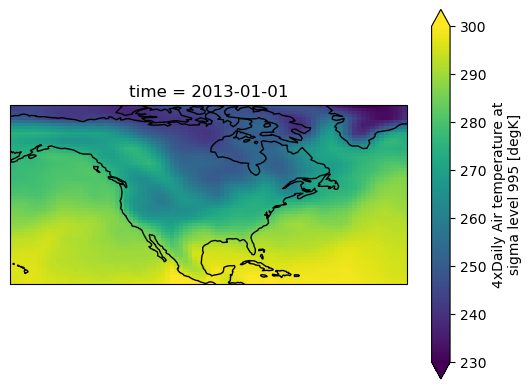

In [15]:
ax = plt.axes(projection=ccrs.PlateCarree())
dr_out.isel(time=0).plot.pcolormesh(ax=ax, vmin=230, vmax=300)
ax.coastlines()

## Check broadcasting over extra dimensions


xESMF tracks coordinate values over extra dimensions, since horizontal
regridding should not affect them.


In [16]:
dr_out["time"]

<xarray.DataArray 'time' (time: 2920)>
array(['2013-01-01T00:00:00.000000000', '2013-01-01T06:00:00.000000000',
       '2013-01-01T12:00:00.000000000', ..., '2014-12-31T06:00:00.000000000',
       '2014-12-31T12:00:00.000000000', '2014-12-31T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    standard_name:  time
    long_name:      Time

In [17]:
# exactly the same as input
xr.testing.assert_identical(dr_out["time"], ds["time"])

We can plot the time series at a specific location, to make sure the
broadcasting is correct:


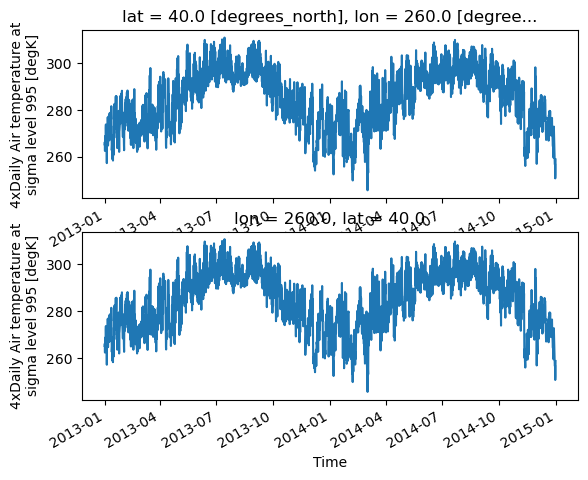

In [18]:
plt.subplot(2, 1, 1)
dr.sel(lon=260, lat=40).plot()  # input data
plt.subplot(2, 1, 2)
dr_out.sel(lon=260, lat=40).plot()  # output data